In [ ]:
# do not include in script
from google.colab import drive
drive.mount('/content/drive')
apple_data_path = '/content/drive/MyDrive/Colab Notebooks'

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
from google.colab.patches import cv2_imshow # google colab specific bugfix
from matplotlib import pyplot as plt
from sklearn.linear_model import RANSACRegressor
import matplotlib.colors as mcolors
import seaborn as sns
import math
# FOR TWO-WAY ANOVA
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests
# FOR TUKEY HSD
import statsmodels.stats.multicomp as mc

In [ ]:
script_path = '/content/drive/MyDrive/Colab Notebooks/utils_apple.py'
apple_data_path = '/content/drive/MyDrive/Colab Notebooks'

# set path for cultivar highlight plots - this is necessary to avoid clutter,
# one folder will be filled with 30-45 plots depending on the number of highlighted cultivars!
plt_output = os.path.join(output_path, 'cultivar_size_consistency')

# for importing the script in script_path
import importlib.util
spec = importlib.util.spec_from_file_location("utils_apple", script_path)
utils_apple = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils_apple)

In [ ]:
badge_annotation = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/subset_annotation_2021_2022.xlsx')
output_path = os.path.join(apple_data_path,'size_ratio_results')
used_cultivars = list(badge_annotation['Cultivar_name'].unique())
used_badges = list(badge_annotation['badge'].unique())

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [ ]:
relevant_locations = ['/content/drive/MyDrive/Colab Notebooks/2021/waedenswil',
                      '/content/drive/MyDrive/Colab Notebooks/2021/grabs',
                      '/content/drive/MyDrive/Colab Notebooks/2022/waedenswil',
                      '/content/drive/MyDrive/Colab Notebooks/2022/grabs']


w2021 = utils_apple.obtain_edge_measurements(path = relevant_locations[0]+'/all.badge.polar.raw.txt')
g2021 = utils_apple.obtain_edge_measurements(path = relevant_locations[1]+'/all.badge.polar.raw.txt')
w2022 = utils_apple.obtain_edge_measurements(path = relevant_locations[2]+'/all.badge.polar.raw.txt')

loading from path /content/drive/MyDrive/Colab Notebooks/2021/waedenswil/all.badge.polar.raw.txt
loading from path /content/drive/MyDrive/Colab Notebooks/2021/grabs/all.badge.polar.raw.txt
loading from path /content/drive/MyDrive/Colab Notebooks/2022/waedenswil/all.badge.polar.raw.txt


In [ ]:
# fix grabs 2022 badge mistake
g2022 = pd.read_csv(relevant_locations[3]+'/all.badge.polar.raw.txt', sep = '\t')
g2022_badges = list(g2022['badge'])
for i in range(len(g2022_badges)):
  g2022_badges[i] = g2022_badges[i][0:4]+'0'+g2022_badges[i][4:]
g2022['badge'] = g2022_badges

g2022 = utils_apple.obtain_edge_measurements(pre_df = g2022, use_df = True)

loading dataframe


In [ ]:
# filter badges and ensure the same badges are used in each year

w2021 = {badge: df for badge, df in w2021.items() if badge in used_badges}
g2021 = {badge: df for badge, df in g2021.items() if badge in used_badges}

w2022 = {badge: df for badge, df in w2022.items() if badge in used_badges}
w2022 = {badge: df for badge, df in w2022.items() if badge in list(w2021.keys())}

g2022 = {badge: df for badge, df in g2022.items() if badge in used_badges}
g2022 = {badge: df for badge, df in g2022.items() if badge in list(g2021.keys())}


In [ ]:
len(w2021), len(g2021), len(w2022), len(g2022), len(used_cultivars)

(438, 686, 438, 686, 318)

In [ ]:
dims_w2021 = pd.read_csv(relevant_locations[0]+'/traits.txt', sep='\t')
dims_w2022 = pd.read_csv(relevant_locations[2]+'/traits.txt', sep='\t')
dims_g2021 = pd.read_csv(relevant_locations[1]+'/traits.txt', sep='\t')
dims_g2022 = pd.read_csv(relevant_locations[3]+'/traits.txt', sep='\t')
# filter badges
dims_w2021 = dims_w2021[dims_w2021['badge'].isin(used_badges)].merge(badge_annotation, left_on='badge', right_on='badge', how='left')
dims_w2022 = dims_w2022[dims_w2022['badge'].isin(used_badges)].merge(badge_annotation, left_on='badge', right_on='badge', how='left')
dims_g2021 = dims_g2021[dims_g2021['badge'].isin(used_badges)].merge(badge_annotation, left_on='badge', right_on='badge', how='left')
# fix grabs 2022 badge mistake
g2022_badges = list(dims_g2022['badge'])
for i in range(len(g2022_badges)):
  g2022_badges[i] = g2022_badges[i][0:4]+'0'+g2022_badges[i][4:]
dims_g2022['badge'] = g2022_badges
dims_g2022 = dims_g2022[dims_g2022['badge'].isin(used_badges)].merge(badge_annotation, left_on='badge', right_on='badge', how='left')

# obtain h-w ratio
dims_w2021['HWratio'] = dims_w2021['height_mean_cm'] / dims_w2021['width_mean_cm']
dims_w2022['HWratio'] = dims_w2022['height_mean_cm'] / dims_w2022['width_mean_cm']
dims_g2021['HWratio'] = dims_g2021['height_mean_cm'] / dims_g2021['width_mean_cm']
dims_g2022['HWratio'] = dims_g2022['height_mean_cm'] / dims_g2022['width_mean_cm']

In [ ]:
# filter badges
dims_w2021.to_csv(os.path.join(output_path, 'traits_filtered_w2021.csv'))
dims_w2022.to_csv(os.path.join(output_path, 'dims_filtered_w2022.csv'))
dims_g2021.to_csv(os.path.join(output_path, 'dims_filtered_g2021.csv'))
dims_g2022.to_csv(os.path.join(output_path, 'dims_filtered_g2022.csv'))



In [ ]:
# combine all datasets into one to plot all apples together
dims_all = pd.concat([dims_w2021, dims_w2022, dims_g2021, dims_g2022], ignore_index=True)

[Source paper](https://www.ecpgr.org/fileadmin/bioversity/publications/pdfs/2022_ECPGR_Malus_descriptors_final.pdf)

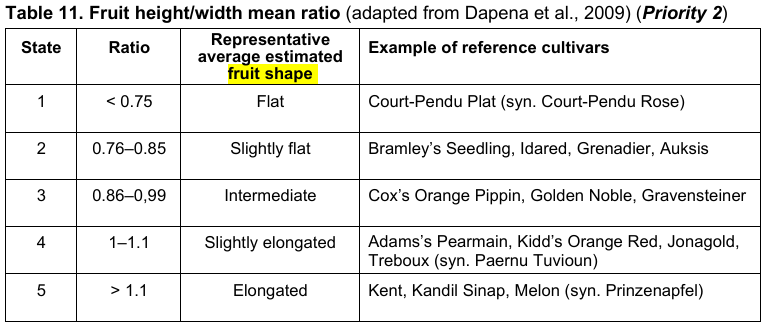

Plot saved successfully as /content/drive/MyDrive/Colab Notebooks/size_ratio_results/Wädenswil 2021 Apple Sizes.png


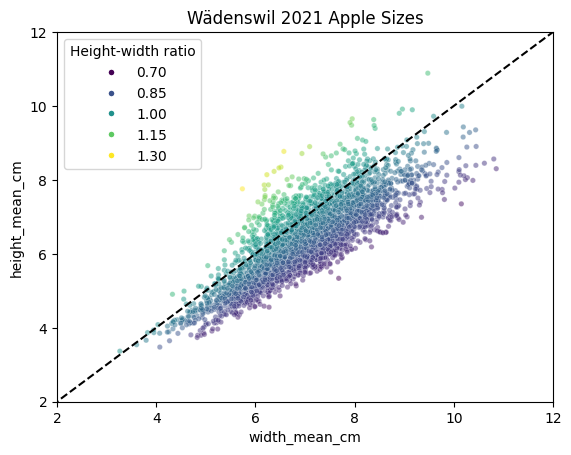

Plot saved successfully as /content/drive/MyDrive/Colab Notebooks/size_ratio_results/Grabs 2021 Apple Sizes.png


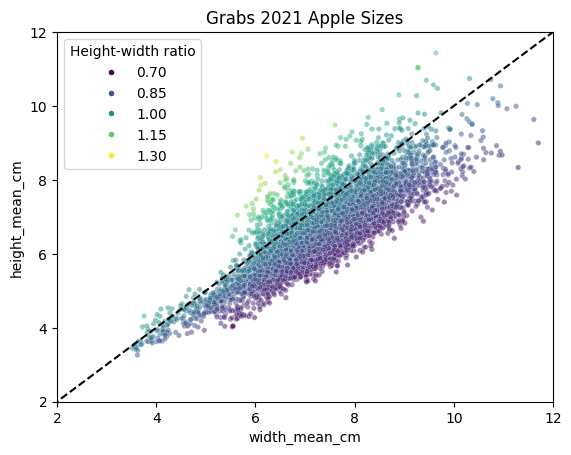

Plot saved successfully as /content/drive/MyDrive/Colab Notebooks/size_ratio_results/Wädenswil 2022 Apple Sizes.png


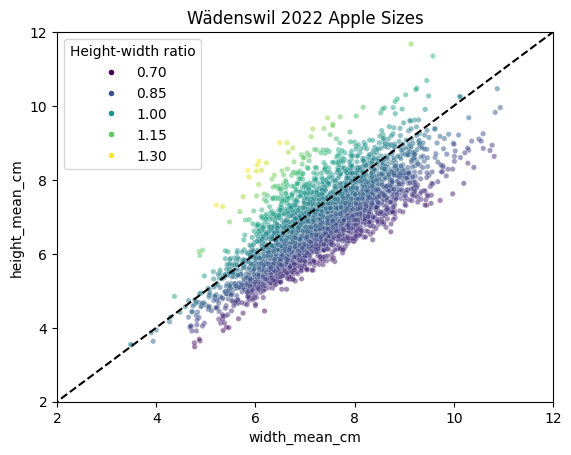

Plot saved successfully as /content/drive/MyDrive/Colab Notebooks/size_ratio_results/Grabs 2022 Apple Sizes.png


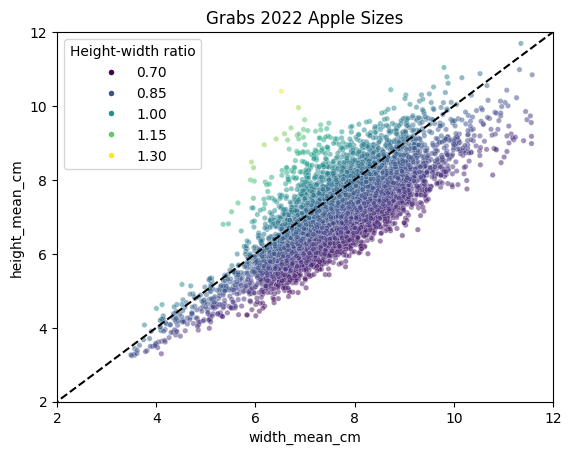

In [ ]:
utils_apple.generate_height_width_plot(dims_w2021[['width_mean_cm','height_mean_cm','HWratio']], output_path,
                                       plot_title = 'Wädenswil 2021 Apple Sizes', xlim = (2,12), ylim = (2,12),
                                       sns_palette = 'viridis')
utils_apple.generate_height_width_plot(dims_g2021[['width_mean_cm','height_mean_cm','HWratio']], output_path,
                                       plot_title = 'Grabs 2021 Apple Sizes', xlim = (2,12), ylim = (2,12),
                                       sns_palette = 'viridis')
utils_apple.generate_height_width_plot(dims_w2022[['width_mean_cm','height_mean_cm','HWratio']], output_path,
                                       plot_title = 'Wädenswil 2022 Apple Sizes', xlim = (2,12), ylim = (2,12),
                                       sns_palette = 'viridis')
utils_apple.generate_height_width_plot(dims_g2022[['width_mean_cm','height_mean_cm','HWratio']], output_path,
                                       plot_title = 'Grabs 2022 Apple Sizes', xlim = (2,12), ylim = (2,12),
                                       sns_palette = 'viridis')

Plot saved successfully as /content/drive/MyDrive/Colab Notebooks/size_ratio_results/Height and width of all apples in Wädenswil and Grabs in 2021 and 2022.png


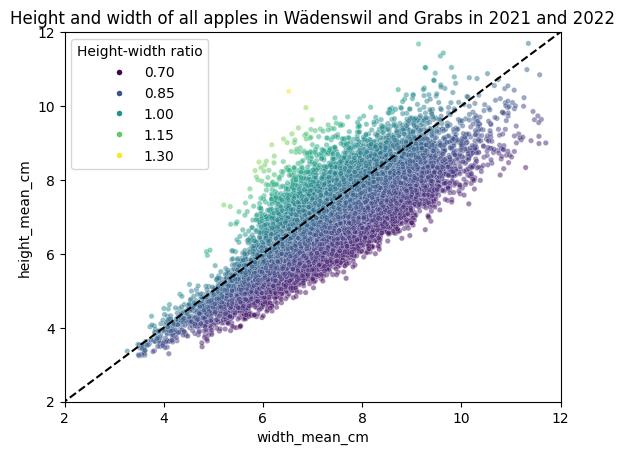

In [ ]:
# plot all apples in one plot
utils_apple.generate_height_width_plot(pd.concat([dims_w2021, dims_w2022, dims_g2021, dims_g2022], ignore_index=True)[['width_mean_cm','height_mean_cm','HWratio']],
                                       output_path, plot_title = 'Height and width of all apples in Wädenswil and Grabs in 2021 and 2022',
                                       xlim = (2,12), ylim = (2,12),
                                       sns_palette = 'viridis')

Identifying cultivars in the height-width plot of locations and years

1. merge dataset with annotation
2. make 2x2 plot location x year
3. highlight 6 cultivars with different color / shape
4. repeat 1-3 until all cultivars are plotted

In [ ]:
utils_apple.plot_cultivar_size_consistency(dataframes=[dims_w2021[['width_mean_cm','height_mean_cm','Cultivar_name']], dims_w2022[['width_mean_cm','height_mean_cm','Cultivar_name']],
                                                       dims_g2021[['width_mean_cm','height_mean_cm','Cultivar_name']], dims_g2022[['width_mean_cm','height_mean_cm','Cultivar_name']]],
                                           n_highlights=6,
                                           plot_title_overall = 'Apple size consistency across 2021 and 2022 in Wädenswil and Grabs',
                                           used_cultivars = used_cultivars, plt_output_path = plt_output)

Output hidden; open in https://colab.research.google.com to view.

Differences in HWratio between two years at the same location: potential effect of biennial bearing? Or just human bias?

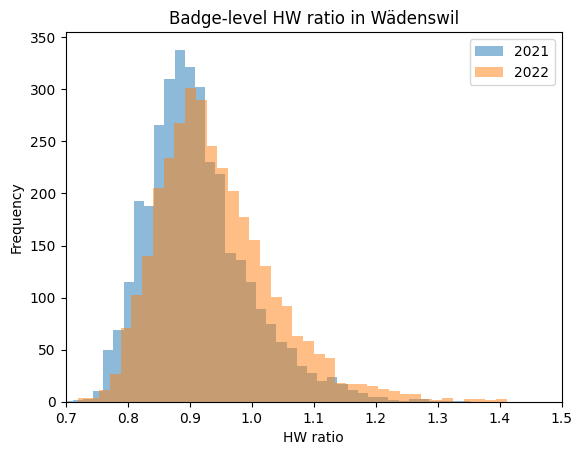

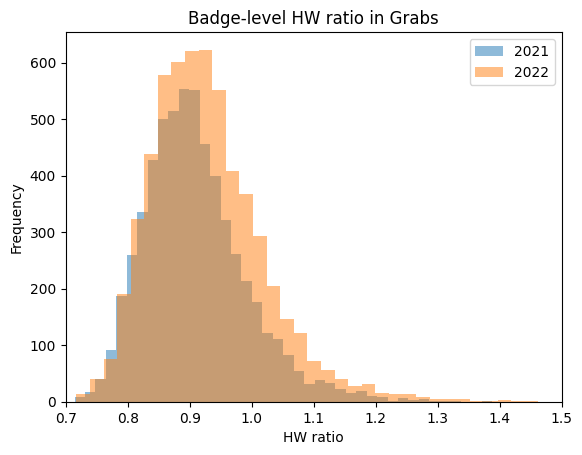

In [ ]:
utils_apple.plot_histogram_of_distances_duo(dfs = (dims_w2021['HWratio'], dims_w2022['HWratio']),
                                            labels = ('2021', '2022'), title = 'Badge-level HW ratio in Wädenswil',
                                            output_path = output_path,
                                            output_name = 'badge_HWratio_wae.png',
                                            x_axis_title = 'HW ratio',
                                            boundaries = (0.7,1.5))

utils_apple.plot_histogram_of_distances_duo(dfs = (dims_g2021['HWratio'], dims_g2022['HWratio']),
                                            labels = ('2021', '2022'), title = 'Badge-level HW ratio in Grabs',
                                            output_path = output_path,
                                            output_name = 'badge_HWratio_gra.png',
                                            x_axis_title = 'HW ratio',
                                            boundaries = (0.7,1.5))

Investigating the variability of cultivar HWratios for each year and location

In [ ]:
dims_w2021

,badge,appleNR,date,ShapeClass_top,weight_g,diameter_mean_cm,diameter_SD_cm,width_mean_cm,width_SD_cm,height_mean_cm,...,symmetry_mean,symmetry_SD,PL-Code,Cultivar_name,tree_nr,row,Locality,collection,Block,HWratio
0,11.93.0.100,1,20210824084850,5,111.9,4.1958,0.54751,6.8989,0.480300,5.6304,...,0.025238,0.009874,14-001-2774,Odo006,28,5,wae,SACC,B,0.816130
1,11.93.0.100,2,20210824084859,4,92.2,3.8854,0.22704,6.3948,0.141610,4.9602,...,0.031589,0.007019,14-001-2774,Odo006,28,5,wae,SACC,B,0.775661
2,11.93.0.100,3,20210824084911,4,133.4,4.3391,0.32763,7.0299,0.429060,5.7823,...,0.025223,0.005793,14-001-2774,Odo006,28,5,wae,SACC,B,0.822529
3,11.93.0.100,4,20210824084920,5,223.4,5.4552,0.41050,8.6349,0.522920,6.5879,...,0.037721,0.004464,14-001-2774,Odo006,28,5,wae,SACC,B,0.762939
4,11.93.0.100,5,20210824084932,4,121.5,4.4493,0.28318,7.0890,0.309180,5.4692,...,0.023469,0.002329,14-001-2774,Odo006,28,5,wae,SACC,B,0.771505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,11.93.0.998,4,20211019133633,3,228.1,5.5858,0.19143,8.1295,0.183390,7.8370,...,0.018911,0.004999,14-001-2554a,Golden_Del._Shay_4/4,57,17,wae,SACC,C,0.964020
3445,11.93.0.998,5,20211019133641,3,131.2,4.2867,0.18838,6.6087,0.091961,6.5944,...,0.017901,0.003148,14-001-2554a,Golden_Del._Shay_4/4,57,17,wae,SACC,C,0.997836
3446,11.93.0.998,6,20211019133648,3,240.9,5.7357,0.19395,8.1833,0.175770,8.4181,...,0.023852,0.013536,14-001-2554a,Golden_Del._Shay_4/4,57,17,wae,SACC,C,1.028693
3447,11.93.0.998,7,20211019133655,4,229.0,5.5993,0.32268,7.9802,0.185720,8.1507,...,0.018260,0.011508,14-001-2554a,Golden_Del._Shay_4/4,57,17,wae,SACC,C,1.021365


In [ ]:
# obtain mean and s.d. of cultivar HWratio - investigating variability of shape
dims_w2021_hwr_agg = dims_w2021.groupby('Cultivar_name')['HWratio'].agg(['mean', 'std'])
dims_w2022_hwr_agg = dims_w2022.groupby('Cultivar_name')['HWratio'].agg(['mean', 'std'])
dims_g2021_hwr_agg = dims_g2021.groupby('Cultivar_name')['HWratio'].agg(['mean', 'std'])
dims_g2022_hwr_agg = dims_g2022.groupby('Cultivar_name')['HWratio'].agg(['mean', 'std'])

dims_w2021_hwr_agg['err'] = dims_w2021_hwr_agg['std']/dims_w2021_hwr_agg['mean']
dims_w2022_hwr_agg['err'] = dims_w2022_hwr_agg['std']/dims_w2022_hwr_agg['mean']
dims_g2021_hwr_agg['err'] = dims_g2021_hwr_agg['std']/dims_g2021_hwr_agg['mean']
dims_g2022_hwr_agg['err'] = dims_g2022_hwr_agg['std']/dims_g2022_hwr_agg['mean']

dims_w2021_hwr_agg.reset_index(inplace=True)
dims_w2022_hwr_agg.reset_index(inplace=True)
dims_g2021_hwr_agg.reset_index(inplace=True)
dims_g2022_hwr_agg.reset_index(inplace=True)

Text(0.5, 1.0, 'Height-width ratio of cultivars and their standard deviation')

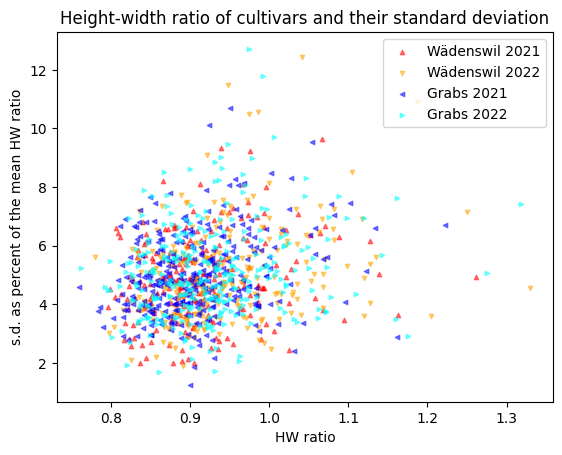

In [ ]:
# residual plot of mean HWratio of a cultivar
plt.scatter(x = dims_w2021_hwr_agg['mean'], y = dims_w2021_hwr_agg['err']*100, s=10, alpha = 0.5, color='red', marker = '^')
plt.scatter(x = dims_w2022_hwr_agg['mean'], y = dims_w2022_hwr_agg['err']*100, s=10, alpha = 0.5, color='orange', marker = 'v')
plt.scatter(x = dims_g2021_hwr_agg['mean'], y = dims_g2021_hwr_agg['err']*100, s=10, alpha = 0.5, color='blue', marker = '<')
plt.scatter(x = dims_g2022_hwr_agg['mean'], y = dims_g2022_hwr_agg['err']*100, s=10, alpha = 0.5, color='cyan', marker = '>')
plt.legend(['Wädenswil 2021', 'Wädenswil 2022', 'Grabs 2021', 'Grabs 2022'])
plt.xlabel('HW ratio')
plt.ylabel('s.d. as percent of the mean HW ratio')
plt.title('Height-width ratio of cultivars and their standard deviation')

In the plot above, points located on the upper part of the plot have more variance in height-width ratio. a difference of more than 10% is visually noticeable and represents a different shape class.

The distribution of residuals seems similar for all locations and years.

In [ ]:
dims_w2021_hwr_agg

,Cultivar_name,HWratio_w2021_mean,HWratio_w2021_std,HWratio_w2021_err
0,ACW_11301,1.021455,0.050404,0.049345
1,ACW_11567,0.895689,0.026173,0.029221
2,ACW_12556,0.899468,0.055761,0.061993
3,ACW_13490,0.974814,0.051475,0.052805
4,ACW_14617,0.892515,0.035045,0.039265
...,...,...,...,...
230,unbekannt_2112,0.975193,0.035328,0.036227
231,unbekannt_2207,0.896254,0.053827,0.060057
232,unbekannt_2215,0.897047,0.033765,0.037640
233,unbekannt_2226,0.841418,0.051050,0.060671


Outputting highlighted cultivar residual plots for each location and year alongside one another

In [ ]:
utils_apple.plot_cultivar_size_consistency(dataframes = [dims_w2021_hwr_agg[['mean','err','Cultivar_name']],dims_w2022_hwr_agg[['mean','err','Cultivar_name']],
                                                         dims_g2021_hwr_agg[['mean','err','Cultivar_name']], dims_g2022_hwr_agg[['mean','err','Cultivar_name']]],
                                           plot_title_overall = 'Apple height-width ratio consistency across 2021 and 2022 in Wädenswil and Grabs',
                                           used_cultivars = used_cultivars, plt_output_path = plt_output+'_hw_ratio', n_highlights=12)

NameError: name 'plt_output' is not defined

In [ ]:
dims_w2021_hwr_agg.columns = ['Cultivar_name', 'HWratio_w2021_mean', 'HWratio_w2021_std', 'HWratio_w2021_err']
dims_w2022_hwr_agg.columns = ['Cultivar_name', 'HWratio_w2022_mean', 'HWratio_w2022_std', 'HWratio_w2022_err']
dims_g2021_hwr_agg.columns = ['Cultivar_name', 'HWratio_g2021_mean', 'HWratio_g2021_std', 'HWratio_g2021_err']
dims_g2022_hwr_agg.columns = ['Cultivar_name', 'HWratio_g2022_mean', 'HWratio_g2022_std', 'HWratio_g2022_err']

merged_df = dims_w2021_hwr_agg.merge(dims_w2022_hwr_agg, on='Cultivar_name', how='outer') \
                           .merge(dims_g2021_hwr_agg, on='Cultivar_name', how='outer') \
                           .merge(dims_g2022_hwr_agg, on='Cultivar_name', how='outer')

merged_df['HWratio_all_mean'] = merged_df[['HWratio_w2021_mean', 'HWratio_w2022_mean', 'HWratio_g2021_mean', 'HWratio_g2022_mean']].mean(axis=1)
merged_df.to_csv(os.path.join(output_path, 'cultivar_hw_ratio_consistency_agg.csv'))

In [ ]:
# calculate intra-cultivar distances (cluster spread) based on height and width
# per cultivar
cultivar_intra_dists = [{},{},{},{}]
for cultivar in used_cultivars:
  cultivar_intra_dists[0][cultivar] = utils_apple.calculate_intra_cultivar_distance(dims_w2021[['height_mean_cm','width_mean_cm','Cultivar_name']], cultivar = cultivar)
  cultivar_intra_dists[1][cultivar] = utils_apple.calculate_intra_cultivar_distance(dims_w2022[['height_mean_cm','width_mean_cm','Cultivar_name']], cultivar = cultivar)
  cultivar_intra_dists[2][cultivar] = utils_apple.calculate_intra_cultivar_distance(dims_g2021[['height_mean_cm','width_mean_cm','Cultivar_name']], cultivar = cultivar)
  cultivar_intra_dists[3][cultivar] = utils_apple.calculate_intra_cultivar_distance(dims_g2022[['height_mean_cm','width_mean_cm','Cultivar_name']], cultivar = cultivar)

# output the intracultivar distances
cultivar_intra_dist_df = pd.DataFrame(cultivar_intra_dists).T
cultivar_intra_dist_df.columns = ['w2021', 'w2022', 'g2021', 'g2022']
cultivar_intra_dist_df.to_csv(os.path.join(output_path, 'cultivar_intra_dist.csv'))

Cultivar unbekannt_1495 could not be found in the dataset.
Cultivar unbekannt_1495 could not be found in the dataset.
Cultivar melo_sconosciuto_2789 could not be found in the dataset.
Cultivar melo_sconosciuto_2789 could not be found in the dataset.
Cultivar rote_Sternreinette could not be found in the dataset.
Cultivar rote_Sternreinette could not be found in the dataset.
Cultivar Pupille=Schweizer_Orangen could not be found in the dataset.
Cultivar Pupille=Schweizer_Orangen could not be found in the dataset.
Cultivar Edelbreiter could not be found in the dataset.
Cultivar Edelbreiter could not be found in the dataset.
Cultivar unbekannt_1811 could not be found in the dataset.
Cultivar unbekannt_1811 could not be found in the dataset.
Cultivar Gieker could not be found in the dataset.
Cultivar Gieker could not be found in the dataset.
Cultivar Edelgrauech could not be found in the dataset.
Cultivar Edelgrauech could not be found in the dataset.
Cultivar Goro could not be found in the 

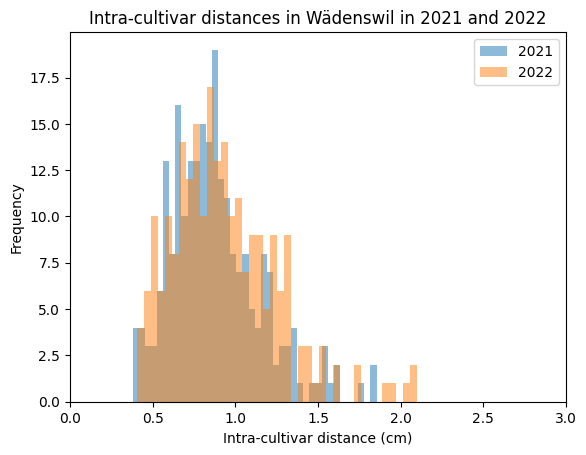

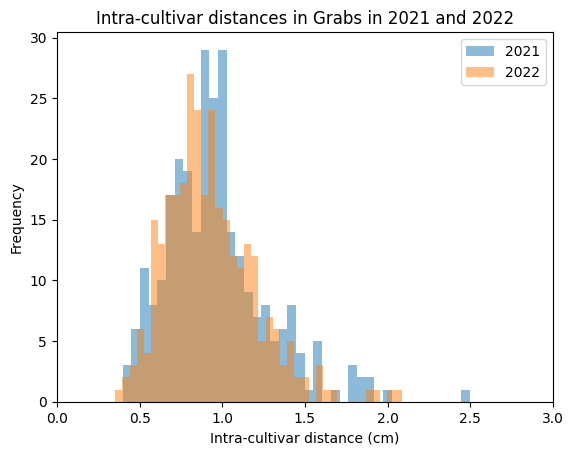

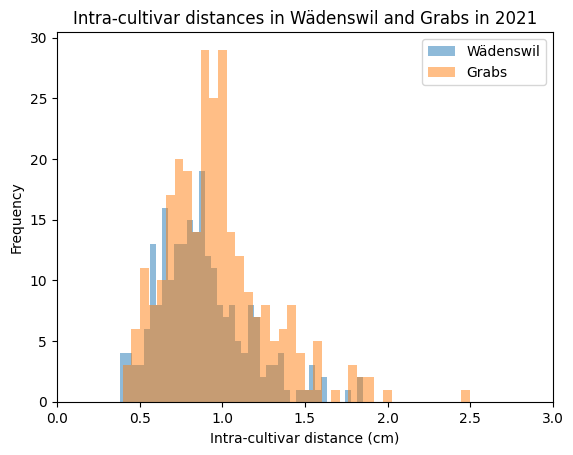

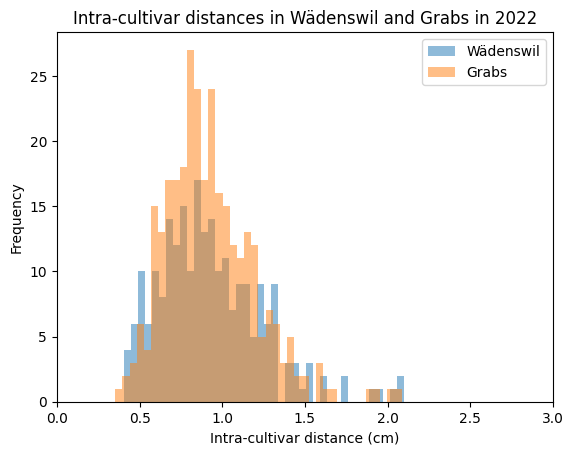

<Figure size 640x480 with 0 Axes>

In [ ]:
# compare two years at the same location
utils_apple.plot_histogram_of_distances_duo(dfs = (cultivar_intra_dist_df['w2021'], cultivar_intra_dist_df['w2022']),
                                            labels = ('2021', '2022'), title = 'Intra-cultivar distances in Wädenswil in 2021 and 2022',
                                            output_name = 'intra_cultivar_distances_wael.png',
                                            output_path = output_path,
                                            x_axis_title = 'Intra-cultivar distance (cm)',
                                            boundaries = (0,3))
utils_apple.plot_histogram_of_distances_duo(dfs = (cultivar_intra_dist_df['g2021'], cultivar_intra_dist_df['g2022']),
                                            labels = ('2021', '2022'), title = 'Intra-cultivar distances in Grabs in 2021 and 2022',
                                            output_name = 'intra_cultivar_distances_grabs.png',
                                            output_path = output_path,
                                            x_axis_title = 'Intra-cultivar distance (cm)',
                                            boundaries = (0,3))
# compare locations within the same year
utils_apple.plot_histogram_of_distances_duo(dfs = (cultivar_intra_dist_df['w2021'], cultivar_intra_dist_df['g2021']),
                                            labels = ('Wädenswil', 'Grabs'), title = 'Intra-cultivar distances in Wädenswil and Grabs in 2021',
                                            output_name = 'intra_cultivar_distances_2021.png',
                                            output_path = output_path,
                                            x_axis_title = 'Intra-cultivar distance (cm)',
                                            boundaries = (0,3))
utils_apple.plot_histogram_of_distances_duo(dfs = (cultivar_intra_dist_df['w2022'], cultivar_intra_dist_df['g2022']),
                                            labels = ('Wädenswil', 'Grabs'), title = 'Intra-cultivar distances in Wädenswil and Grabs in 2022',
                                            output_name = 'intra_cultivar_distances_2022.png',
                                            output_path = output_path,
                                            x_axis_title = 'Intra-cultivar distance (cm)',
                                            boundaries = (0,3))

## Two-way ANOVA



In [ ]:
# add year and location to all entries of the respective dataframe for concatenation
w2021_data = dims_w2021[['Cultivar_name', 'HWratio']].assign(Year=2021, Location='wae')
w2022_data = dims_w2022[['Cultivar_name', 'HWratio']].assign(Year=2022, Location='wae')
g2021_data = dims_g2021[['Cultivar_name', 'HWratio']].assign(Year=2021, Location='gra')
g2022_data = dims_g2022[['Cultivar_name', 'HWratio']].assign(Year=2022, Location='gra')

anova_data = pd.concat([w2021_data, w2022_data, g2021_data, g2022_data]).dropna()

# Print the ANOVA table
print(anova_table)

Effect of cultivar, year, location (and interactions) on the height-width ratio

In [ ]:
# for two-way ANOVA: independent and interacting location and year
# try all data, including cultivar as factor
model_overall = sm.ols('HWratio ~ Cultivar_name + Year + Location + Cultivar_name:Year + Cultivar_name:Location + Year:Location + Cultivar_name:Year:Location',
               data=anova_data)
results = model_overall.fit()
anova_table = anova_lm(results)

                                  df     sum_sq   mean_sq           F  \
Cultivar_name                  317.0  94.168130  0.297060  123.440500   
Location                         1.0   0.229069  0.229069   95.187179   
Cultivar_name:Location         317.0   2.787741  0.008794    3.654316   
Year                             1.0   2.354348  2.354348  978.325959   
Cultivar_name:Year             317.0   4.304677  0.013579    5.642795   
Year:Location                    1.0   0.076323  0.076323   31.715200   
Cultivar_name:Year:Location    317.0   1.753324  0.005531    2.298349   
Residual                     17465.0  42.029633  0.002407         NaN   

                                    PR(>F)  
Cultivar_name                 0.000000e+00  
Location                      1.976361e-22  
Cultivar_name:Location        6.074329e-92  
Year                         5.177465e-209  
Cultivar_name:Year           8.550596e-191  
Year:Location                 1.812676e-08  
Cultivar_name:Year:Location

In [ ]:
anova_data

,Cultivar_name,HWratio,Year,Location
0,Odo006,0.816130,2021,wae
1,Odo006,0.775661,2021,wae
2,Odo006,0.822529,2021,wae
3,Odo006,0.762939,2021,wae
4,Odo006,0.771505,2021,wae
...,...,...,...,...
5900,Kitquap,1.023694,2022,gra
5901,Kitquap,1.022395,2022,gra
5902,Kitquap,0.994003,2022,gra
5903,Kitquap,0.980198,2022,gra


## Tukey HSD test

In [ ]:
# Tukey-HSD test
# cultivar diff - TAKES FOREVER!!! DON'T RERUN, JUST LOOK AT ALREADY GENERATED OUTPUT TABLES
#comp = mc.MultiComparison(anova_data['HWratio'], anova_data['Cultivar_name'])
#post_hoc_res_cultivar = comp.tukeyhsd()

# year diff
comp = mc.MultiComparison(anova_data['HWratio'], anova_data['Year'])
post_hoc_res_year = comp.tukeyhsd()

# location diff
comp = mc.MultiComparison(anova_data['HWratio'], anova_data['Location'])
post_hoc_res_location = comp.tukeyhsd()

In [ ]:
pd.DataFrame(post_hoc_res_cultivar.summary()).to_csv(os.path.join(output_path, 'tukey_post_hoc_cultivar.csv'))
pd.DataFrame(post_hoc_res_year.summary()).to_csv(os.path.join(output_path, 'tukey_post_hoc_year.csv'))
pd.DataFrame(post_hoc_res_location.summary()).to_csv(os.path.join(output_path, 'tukey_post_hoc_location.csv'))

In [ ]:
# Tukey-HSD for interactions: two way anova doesn't work per se, but by combining columns, it can be imitated
anova_data['Year_Location'] = anova_data['Year'].astype(str) + '_' + anova_data['Location']

# year : location diffs
comp = mc.MultiComparison(anova_data['HWratio'], anova_data['Year_Location'])
post_hoc_res_interaction = comp.tukeyhsd()

pd.DataFrame(post_hoc_res_interaction.summary()).to_csv(os.path.join(output_path, 'tukey_post_hoc_interaction.csv'))

print(post_hoc_res_interaction.summary())

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
2021_gra 2021_wae   0.0041 0.1259 -0.0007  0.009  False
2021_gra 2022_gra   0.0187    0.0  0.0145 0.0229   True
2021_gra 2022_wae   0.0339    0.0   0.029 0.0388   True
2021_wae 2022_gra   0.0146    0.0  0.0097 0.0194   True
2021_wae 2022_wae   0.0297    0.0  0.0242 0.0352   True
2022_gra 2022_wae   0.0152    0.0  0.0102 0.0201   True
-------------------------------------------------------


## Saving TukeyHSD results into a separate folder, one file comparing years and locations effect per cultivar.

In [ ]:
# obtain individual data per cultivar, comparing year and location
model_cultivars = {}
anova_cultivars = {}

output_anova_tukey = os.path.join(output_path, 'anova_tukeyHSD')
if not os.path.exists(output_anova_tukey):
  os.mkdir(output_anova_tukey)

for cultivar in used_cultivars:
  model_cultivars[cultivar] = sm.ols('HWratio ~ Year + Location + Year:Location',
                                  data=anova_data[anova_data['Cultivar_name'] == cultivar]).fit()

  # run Tukey HSD per cultivar
  comp_cultivar = mc.MultiComparison(anova_data[anova_data['Cultivar_name'] == cultivar]['HWratio'],
                            anova_data[anova_data['Cultivar_name'] == cultivar]['Year_Location'])

  post_hoc_res_interaction = comp_cultivar.tukeyhsd()
  # save Tukey HSD per cultivar output
  pd.DataFrame(post_hoc_res_interaction.summary()).to_csv(os.path.join(output_anova_tukey, f'tukey_post_hoc_year_location_{cultivar}.csv'))

  anova_cultivars[cultivar] = anova_lm(model_cultivars[cultivar])

OSError: Cannot save file into a non-existent directory: '/content/drive/MyDrive/Colab Notebooks/size_ratio_results/anova_tukeyHSD/tukey_post_hoc_year_location_Golden_Del._Shay_4'

In [ ]:
# extract pvalues only
pval_df = pd.DataFrame()
for cultivar in used_cultivars:
  # put p-value = 1 for comparisons that could not be made (missing in wae)
  new_pvals = anova_cultivars[cultivar].loc[['Location', 'Year', 'Year:Location'], 'PR(>F)'].fillna(1)
  new_pvals.name = cultivar
  pval_df = pd.concat([pval_df, new_pvals], axis=1)

In [ ]:
pval_df.T

,Location,Year,Year:Location
unbekannt_1991,0.762425,0.987119,0.828818
Rotwiler,0.027033,0.307197,1.000000
Malzicher,0.039019,0.000370,0.014045
Maigold,0.092538,0.003382,0.364577
Selvatico,0.000121,0.000251,0.171210
...,...,...,...
Battiorette,1.000000,0.820775,1.000000
Die_Suessen,1.000000,0.831729,1.000000
Reinacher,1.000000,0.011732,1.000000
Bubenkopf,1.000000,0.119347,1.000000


In [ ]:
_, adjusted_p_values_location, _, _ = multipletests(pval_df.loc['Location'], alpha=0.05, method='fdr_bh')
_, adjusted_p_values_year, _, _ = multipletests(pval_df.loc['Year'], alpha=0.05, method='fdr_bh')
_, adjusted_p_values_location_year, _, _ = multipletests(pval_df.loc['Year:Location'], alpha=0.05, method='fdr_bh')

In [ ]:
# replace with adjusted pvalues
pval_df.loc['Location'] = adjusted_p_values_location
pval_df.loc['Year'] = adjusted_p_values_year
pval_df.loc['Year:Location'] = adjusted_p_values_location_year

In [ ]:
# save FDR-corrected pvalue results per cultivar
pval_df.T.to_csv(os.path.join(anova_plot_path, 'pvalues_cultivars.csv'))

In [ ]:
anova_plot_path = os.path.join(output_path, 'anova_plots')
if not os.path.exists(anova_plot_path):
  os.mkdir(anova_plot_path)

pval_df.to_csv(os.path.join(anova_plot_path, 'pvalues_cultivars.csv'))

for cultivar, anova_result in anova_cultivars.items():
  # obtain p-values
  cultivar_data = anova_data[anova_data['Cultivar_name'] == cultivar]

  plt.figure()
  sns.stripplot(x='Year', y='HWratio', hue='Location', data=cultivar_data, jitter=True, dodge=True)
  plt.title(f'Jitter Plot for {cultivar} apples in Wädenswil and Grabs, 2021-2022,\nwith two-way ANOVA significance results')

  # highlight p values
  p_values_curr = pval_df[cultivar]
  if any(p_values_curr < 0.05):
    # highlight p values if they are below 0.05
    significant_effects = p_values_curr[p_values_curr < 0.05]
    p_values_str = ', '.join([f'{effect}: {p:.6f}' for effect, p in zip(significant_effects.index, p_values_curr[p_values_curr < 0.05])])
    plt.text(0.05, 0.95, f'Significant ({p_values_str})', transform=plt.gca().transAxes, color='red', fontsize=10)
    plt.ylim(0.6,1.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    cultivar = cultivar.replace('/','_')
    plt.savefig(os.path.join(anova_plot_path, f'anova_jitter_plot_{cultivar}.png'))
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# SCRATCH

Explore more of the data here